# For this version, i compare the results of different dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# I. Writing all functions that we need to use later

## 1. Feature scaling


In [2]:
def scaler(X_tra, X_te, scaler="minmax"):
  """
  Feature scaling using MinMaxScaler oder StandardScaler

  Arguments:
  X_tra -- traing dataset before scaling
  X_te -- test dataset before scaling
  scaler -- scaler methods: minmax = MinMaxScaler; standard = StandardScaler

  Returns:
  X_train -- scaled training set
  X_test -- scaled test set
  """
  from sklearn.preprocessing import MinMaxScaler, StandardScaler

  if scaler == "standard":
    sc = StandardScaler()
  else:
    sc = MinMaxScaler(feature_range=(0, 1))
  
  X_train = sc.fit_transform(X_tra.copy())
  X_test = sc.transform(X_te.copy())
  return X_train, X_test

## 2. Create Autoencoder Model

In [3]:
# Create a model by subclassing Model class in tensorflow
class Autoencoder(Model):
  """
  An autoencoder with Encoder and decoder blocks and adjustable size of laten space
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
    latent -- size of laten space layer
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim, latent):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

### 2.a. Training model using the loss function `Mean Square Error`:

Pros of mse:
  * MSE penalises the model for having huge errors by squaring them.
  * It is particularly helpful in weeding out outliers with large errors from the model by putting more weight on them.

**source:** https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

In [4]:
def training_model(model_architecture, X_train, X_test, latent = 4, verbose = 0, loss = "mse", epochs=50, batch_size=128):
  """
  training a model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    X_train  -- input data
    X-test -- test data
    latent -- the size of latent space applied for model_architecture
    loss -- the loss metrics is used for training model
    epochs -- number of training loops
    batch_size
    verbose -- showing progress of trainin model

  Returns:
    autoencoder -- the trained model
    history -- the history of trained model
  """
  # Set random seed
  #tf.keras.utils.set_random_seed(42)

  # Create autoencoder model
  autoencoder = model_architecture(input_dim=X_train.shape[1], latent = latent)

  # callback will stop the training when there is no improvement in the loss for 7 consecutive epochs
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

  # Loss and optimizer definition
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=loss,  #  Computes the mean of squares of errors between y_true & y_pred.
                      metrics=[loss]) 

  # Fit the autoencoder
  history= autoencoder.fit(x=X_train, 
                          y=X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose = verbose,
                          callbacks = [callback],
                          validation_split=0.2,   # Fraction of the training data to be used as validation data
                          shuffle=True)
  return autoencoder, history

### 2.b. Function to measure the performance of model in detecting outlier

https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot

In [5]:
def performance(model, X_test, y_test, plot = True):
  """
  Measure performance of trained model mit AUC score using built-in function in sklearn

  Arguments:
    model -- trained model
    X_test -- data which are used to test the trained model
    y_test -- this contains labels of X_test. 
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    AUC -- the AUC score
    ROC curve
  """

  # getting predictions (recontructions) of the test data
  preds = model.predict(X_test)
  # calculate the difference between predictions and test data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_test)
  # Check the prediction performance
  auc_score = roc_auc_score(y_test, pred_errors)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 2.c. Check the effect of laten space on the model.


In [6]:
def effect_latent(model_architecture, X_train, X_test, y_test, latent_list, loss = "mse", epochs=50, batch_size=128, print=False):
  """
  This function will check the effect of the size of laten space on the model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent_list -- list contains the sizes of laten space that we want to use for our model

  Returns:

  """
  # list contains auc_score of trained models
  auc_list = []
  # training model with different sizes of latent space
  for i in latent_list:
    model, hist = training_model(model_architecture, X_train, X_test, latent = i, loss = loss, epochs=epochs, batch_size=batch_size)

    #getting predictions (recontructions) of the test data
    preds = model.predict(X_test)
    # calculate the difference between predictions and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    auc_list.append(auc_score)
    if print:
     print(f"Latent = {i}: AUC score = {auc_score}")

  # plot the effect of latent space on trained models
  plt.plot(latent_list, auc_list)
  plt.title('The effect of latent space on models')
  plt.xlabel("Latent size")
  plt.ylabel("AUC score")
  plt.show()

## 3.  Test new architecture of model

Adding one more hidden layer in architecture model of Autoencoder. But the result of trained model based on new AutoencoderV2 is worse than Autoencoder. So we use the architecture of Autoencoder


## 4. Ensemble Model

Build not only a single autoencoder, but an ensemble of them: 

  * first build multiple autoencoder (in a loop)
  * then average their anomaly scores (first calculate the difference between inputs and theirs predictions, then average it)
  * Calculate the final auc score

Then create a plot, showing how this final auc score depends on the
number of models used.


*Example for using tf.math.reduce_mean()*: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-row-wise.jpg?ssl=1

# II. Testing with different datasets

## 0. Getting data

three datasets: `cardio.npz`, `gas-drift.npz`, `satellite.npz`

A dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [9]:
# This code allows us to upload data from local drive
from google.colab import files
uploaded = files.upload()

Saving satellite.npz to satellite.npz


In [10]:
cardio = np.load('cardio.npz')
gas_drift = np.load('gas-drift.npz')
satellite = np.load('satellite.npz')

In [11]:
def extract_data(dataset):
  """
  This function extract X_train, X_test, y_test from a dataset and apply MinMaxScaler on X_train, X_test

  Arguments:
    dataset -- a dataset contains features x, tx, ty

  Returns:
  X_train: scaled x
  X_test: scaled tx
  y_test: ty
  """
  X_tra = dataset['x']
  X_te = dataset['tx']
  y_test= dataset['ty']
  # Feature scaling
  X_train, X_test = scaler(X_tra, X_te, scaler="minmax")
  return X_train, X_test, y_test

In [12]:
def info(data:list):
  """
  This function prints out an overview of all training datasets in data list in a dataframe
  
  Arguments:
    data -- a list of datasets
  
  Returns:
    a dataframe with name of dataset, shape, ndim, min, max
  """

  df = {'dataset':['cardio', 'gas-drift', 'satellite'],
        'shape': [],
        'ndim': [],
        'min': [],
        'max':[]}
  for da in data:
    df['shape'].append(da['x'].shape)
    df['ndim'].append(da['x'].ndim)
    df['min'].append(da['x'].min())
    df['max'].append(da['x'].max())
  info = pd.DataFrame.from_dict(df)
  return info

In [13]:
info = info([cardio, gas_drift, satellite])
info

,dataset,shape,ndim,min,max
0,cardio,"(1479, 21)",2,-3.004892,14.025335
1,gas-drift,"(1796, 128)",2,-4839.446289,231364.171875
2,satellite,"(3080, 36)",2,31.000000,139.000000


## 1. Inspect the effect of autoencoder on the models

* plot the auc scores of models trained with Autoencoder architecture

In [14]:
def inspect_autoencoder(model_architecture, latent_list: list, data: list, legend: list, epochs):
  """
  This function calculate auc scores of datasets using autoencoder model and  show us the ROC curve and AUC score 

  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    legend -- name of datasets used to display on plot
  Returns:
    aut_dict -- this dictionary contains auc scores of datasets
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  
  aut_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # create and train autoencoder for each dataset
    autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent_list[n], epochs=epochs)
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    aut_dict['auc'].append(auc_score)

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
    
  plt.legend(loc='lower right')
  plt.title('Receiver Operating Characteristic using Autoencoder ')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return aut_dict

83/83 [==============================] - 1s 5ms/step


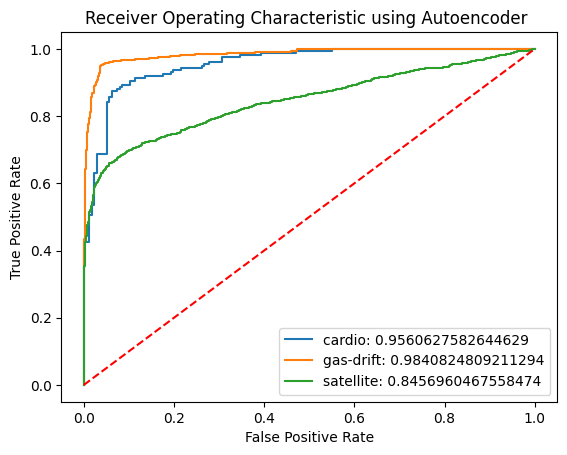

In [15]:
aut_dict = inspect_autoencoder(Autoencoder, latent_list = [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500)

83/83 [==============================] - 1s 4ms/step


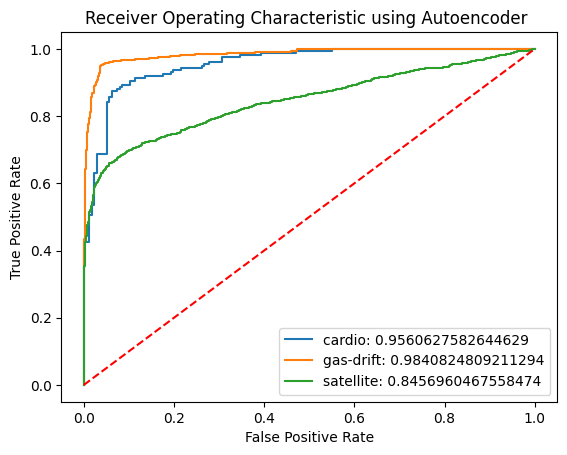

In [16]:
aut_dict_2 = inspect_autoencoder(Autoencoder, latent_list = [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1000)

## 2. Inspect the effect of latent space on the models

* We inspect the correlation between size of latent space and AUC score of models of different datasets

In [19]:
def inspect_latent(model_architecture, latent_list: list, data:list, legend:list, epochs):
  """
  This function show us the correlation between latent space and AUC score
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs
  Returns:
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)

  for df in data:
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list contains auc_score of trained models
    auc_list = []
    # training model with different sizes of latent space
    for i in latent_list:
      model, hist = training_model(model_architecture, X_train, X_test, latent = i, loss = 'mse', epochs=epochs, batch_size=128)

      #getting predictions (recontructions) of the test data
      preds = model.predict(X_test)
      # calculate the difference between predictions and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # Check the prediction performance
      auc_score = roc_auc_score(y_test, pred_errors)
      auc_list.append(auc_score)

    # plot the effect of latent space on trained models
    plt.plot(latent_list, auc_list)
    
  plt.legend(legend, loc='lower right')
  plt.title('The effect of latent space on models')
  plt.xlabel("Latent size")
  plt.ylabel("AUC score")
  plt.show()


83/83 [==============================] - 1s 6ms/step


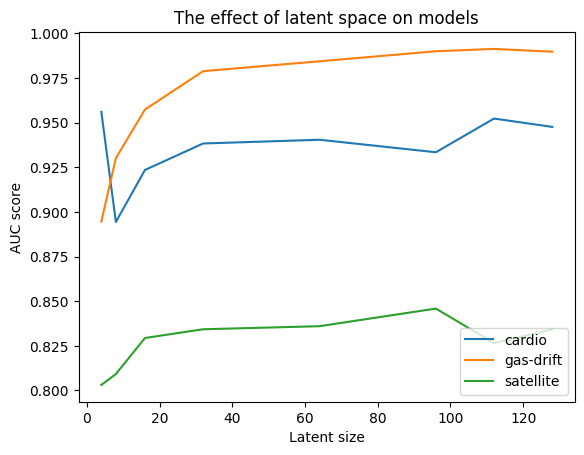

In [21]:
inspect_latent(Autoencoder, latent_list = [4, 8, 16, 32, 64, 96, 112, 128] , data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs=500)

## 3. inspect the effect of ensemble model on datasets

* We inspect the correlation between AUC score and the ensembel model, which contains models with the same architecture, but `different random seed`
* best latent space for each dataset:

  * cardio: 4
  * gas-drift: 112
  * satellite: 64

In [36]:
def inspect_ensemble(model_architecture, seed_list, latent_list: list, data:list, legend:list, epochs):
  """
  This function show us AUC score of datasets trained by using ensemble model. Ensemble model contains models with the same architecture, but different random seed
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    seed_list -- a list of numbers which are used to set random seed for the model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    plot
    ensemble_dict - this dictionary contains auc scores of datasets trained by ensemble model
  """
  ensemble_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # create and train ensemble model for each dataset
    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    pred_errors_list = []

    for SEED in seed_list:
      # set random seed
      tf.keras.utils.set_random_seed(SEED)
      # create autoencoder model
      autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent_list[n], epochs=epochs)
      # getting predictions (recontructions) of the test data
      preds = autoencoder.predict(X_test)
      # calculate the difference between preds and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # append pred_error to the pred_errors_list
      pred_errors_list.append(pred_errors)

    # convert pred_errors_list to a tensor
    preds_tensor = tf.convert_to_tensor(pred_errors_list)
    # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise
    avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
    auc_score = roc_auc_score(y_test, avg_preds)
    ensemble_dict['auc'].append(auc_score)

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
    
  plt.legend(loc='lower right')
  plt.title('ROC of ensemble models')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return ensemble_dict

83/83 [==============================] - 0s 3ms/step


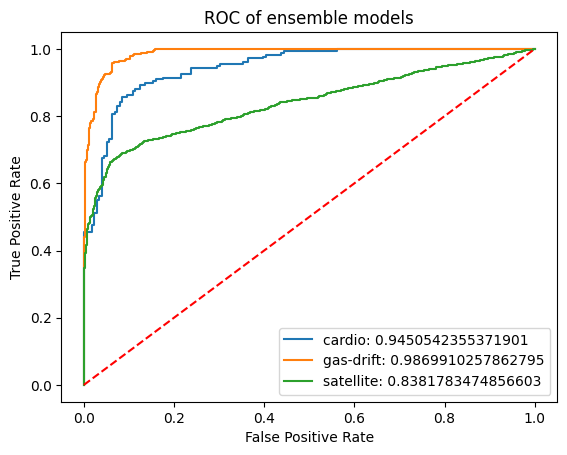

In [37]:
ensemble_dict_2 = inspect_ensemble(Autoencoder, [0, 7, 42, 24], [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500 )

## 4. Inspect the effect of sequential_synchronizing on datasets

In [28]:
def inspect_sequential_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    sesyn_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  sesyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    
    # list of pred_errors. Each element contains all the difference between training data and their predictions of one model
    avg_pred_errors_list = []
    # list of test_errors. Each element contains all the difference between test data and their predictions on one model
    test_errors_list = []
    X = X_train.copy()
    X_te = X_test.copy()

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i-1 to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array.
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X
        X = np.concatenate((X, pred_current), axis=1)
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_te = np.concatenate((X_te, pred_test_current), axis=1)

      # training model
      autoencoder, history = training_model(model_architecture, X, X_te, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)

      # getting predictions (recontructions) of the training data
      preds = autoencoder.predict(X)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_te)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_te))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)

    # 4. Calculating AUC score of each training model 
    auc_score = roc_auc_score(y_test, test_errors_list[-1])
    sesyn_dict['auc'].append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, test_errors_list[-1])
      plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
   
  plt.legend(loc='lower right')
  plt.title('ROC of sequential synchronizing models')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return sesyn_dict

83/83 [==============================] - 0s 5ms/step


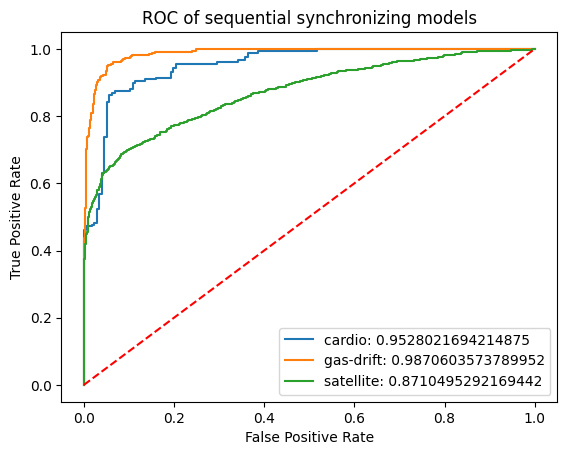

In [29]:
sesyn_dict = inspect_sequential_synchronizing(Autoencoder, 10, latent_list= [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500)

## 5. drop_synchronizing_ensemble

only the prediction errors of the last trained model are used as a feature in the data used to train the next model

In [31]:
def inspect_drop_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    auc_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  dropsyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    avg_pred_errors_list = []
    test_errors_list = []
    auc_score_list = []
    X_plus_one = X_train.copy()
    X_test_one = X_test.copy()

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # only the prediction errors of the last model is concatenated to the original training data before training the next one
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
      
      # training model
      autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
      
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_test_one)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)

    # 4. Calculating AUC score of each training model 
    auc_score = roc_auc_score(y_test, test_errors_list[-1])
    dropsyn_dict['auc'].append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, test_errors_list[-1])
      plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
   
  plt.legend(loc='lower right')
  plt.title('ROC of drop synchronizing models')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return dropsyn_dict

83/83 [==============================] - 0s 4ms/step


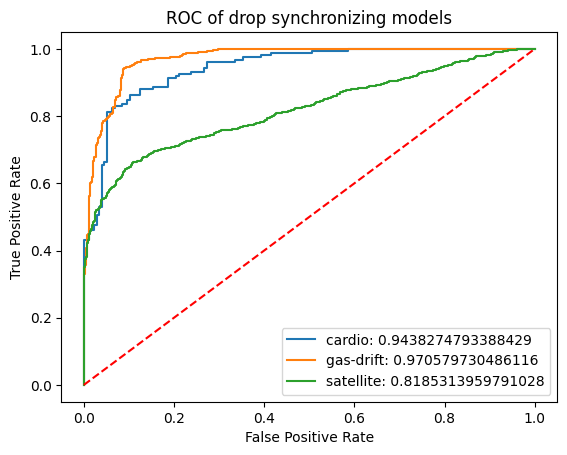

In [32]:
dropsyn_dict = inspect_drop_synchronizing(Autoencoder, 10, latent_list= [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500)

## 6. full_drop_synchronizing

only the prediction errors of the last trained model are used as features in the data used to train the next model. In this case, we keep the shape of prediction errors instead of reshape them to get only one feature

In [34]:
def inspect_full_drop_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    auc_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  fullsyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    pred_errors_list = []
    test_errors_list = []
    errors_list = []
    X_plus_one = X_train.copy()
    X_test_one = X_test.copy()

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
      if pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(pred_errors_list[i-1], [X_train.shape[0], -1]).numpy()
        # only the prediction errors of the last model is concatenated to the original training data before training the next one
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_test_current = tf.reshape(test_errors_list[i-1], [X_test.shape[0], -1]).numpy()
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
      
      # training model
      autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
      
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # append pred_errors to the avg_pred_errors_list
      pred_errors_list.append(pred_errors)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_test_one)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(pred_errors_test)
      # calculate auc score
      errors_test = tf.keras.losses.mse(preds_test, X_test_one)
      errors_list.append(errors_test)

    # 4. Calculating AUC score of each training model 
    # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
    auc_score = roc_auc_score(y_test, errors_list[-1])
    fullsyn_dict['auc'].append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, errors_list[-1])
      plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
   
  plt.legend(loc='lower right')
  plt.title('ROC of full drop synchronizing models')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return fullsyn_dict

83/83 [==============================] - 0s 5ms/step


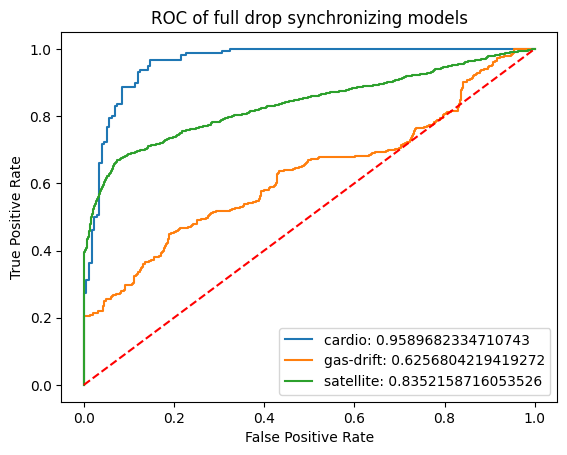

In [35]:
fullsyn_dict = inspect_full_drop_synchronizing(Autoencoder, 5, latent_list= [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500)

* When I try to change 10 models by using full_drop_synchronizing, it comes up with an error. The reason is that for each model, we add double features of the previous trained model. So it is a huge amount of features shoul be added to the next model. 
* I think one reason for the bad result of dataset `satellite`, when we use `full_drop_synchronizing_ensemble` is because the original training set has a big amount of features (128). So each time we try to double it. when a model is trained by using so many features of training data, the result is bad

## 7. Summarizing the results of trained models

* all datasets are trained with epochs=500
* latent space:
  * cardio: 4
  * gas-drift: 112
  * satellite: 64


In [39]:
# create a dictionary contains all AUC scores of all datasets for each type of model was used to train
result_dict = {'Autoencoder': aut_dict['auc'],
               'Ensemble': ensemble_dict_2['auc'],
               'sequential synchronizing': sesyn_dict['auc'],
               'drop synchronizing': dropsyn_dict['auc'],
               'full drop synchronizing': fullsyn_dict['auc']}

results = pd.DataFrame.from_dict(result_dict, orient='index', columns=['cardio', 'gas-drift', 'satellite'])

In [40]:
results

,cardio,gas-drift,satellite
Autoencoder,0.956063,0.984082,0.845696
Ensemble,0.945054,0.986991,0.838178
sequential synchronizing,0.952802,0.987060,0.871050
drop synchronizing,0.943827,0.970580,0.818531
full drop synchronizing,0.958968,0.625680,0.835216


In [41]:
info

,dataset,shape,ndim,min,max
0,cardio,"(1479, 21)",2,-3.004892,14.025335
1,gas-drift,"(1796, 128)",2,-4839.446289,231364.171875
2,satellite,"(3080, 36)",2,31.000000,139.000000
